# FIT5196 Assignment 3

#### Student Name:  Shihan Zhang

#### Student ID:        31268102

Date: 17/11/2020

Version: 3.0

Environment: Python 3.6.0 and Anaconda 4.3.0 (64-bit)

# Library & packages

In [1484]:
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
from tabula import read_pdf
from math import radians, cos, sin, asin, sqrt
from haversine import haversine, Unit
from datetime import datetime
import re
import json
import lxml
import xml.etree.ElementTree as ET 
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [1485]:
import numpy
import matplotlib 
%matplotlib inline
import shapefile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

# Task 1
## Workflow
In this task, Our purpose is to gather relevant data into real estate dat and output a complete data frame, so we need to calculate and backfill data. 
To achieve the goal, we have following steps:
1. Read all source data
2. Backfill data, In this step, we have two types of opreations:
    - 2.1 simple calculation, backfill calculation result, gather data by primary key from other data frame.
    - 2.2 complex calculation, process data by primary key associate with different data frames then back fill the calculation result.
3. Write final data frame to csv file.

In [1273]:
# component function
def rest_index(df):
    df = df.rename(columns=df.iloc[0])
    df = df.iloc[1:]
    df.reset_index(drop=True, inplace=True)
    return df

## 1.1 Read source data

In [1274]:
# read JSON real state id
rs_data = pd.read_json('C:/Users/SENMS/Desktop/5196/31268102/real_state.json')

### Add new column to `rs_data`.
The base data frame `rs_data` no don't include the necessary columns, so we need to add them manually and filling with default values.
#### Shopping center section
 - `Shopping_center_id`
 - `Distance_to_sc`
 
#### Train station section 
 - `Train_station_id` 
 - `Distance_to_train_station`
 - `travel_min_to_CBD` 
 - `Transfer_flag`
 
#### Hospital section
 - `Distance_to_hospital`
 - `Supermarket_id`
 - `Distance_to_supermaket`

In [1275]:
# add New column to rs_data
rs_data['suburb'] = "not available"
rs_data['Shopping_center_id'] = "not available"
rs_data['Distance_to_sc'] = 0.0
rs_data['Train_station_id'] = 0
rs_data['Distance_to_train_station'] = 0.0
rs_data['travel_min_to_CBD'] = 0.0
rs_data['Transfer_flag'] = -1
rs_data['Hospital_id'] = "not available"
rs_data['Distance_to_hospital'] = 0.0
rs_data['Supermarket_id'] = "not available"
rs_data['Distance_to_supermaket'] = 0.0
#rs_data.head()

In [1276]:
# read XML real state data
with open("C:/Users/SENMS/Desktop/5196/31268102/real_state.xml", "r") as file:
    # Read each line in the file, readlines() returns a list of lines
    content = file.readlines()
# get real_state ids    
rs_ids = re.findall(r'(?:<n\d+ \w+\W+\w+\W>)(\d+)(?:</n\d+>)', str(content))

In [1277]:
# read XLSX shopping center data
sc_data = pd.read_excel('C:/Users/SENMS/Desktop/5196/31268102/shopingcenters.xlsx', index_col=0)

In [1278]:
# read HTML hospitial data
hospitals = open('C:/Users/SENMS/Desktop/5196/31268102/hospitals.html', 'r')
htmlhandle = hospitals.read()
page_content = bs(htmlhandle, 'lxml')
# extract table as df
hosp_data = pd.read_html(str(page_content), index_col=0)
hospitals = hosp_data[0]

In [1279]:
# read PDF supermarket data
sm_data = read_pdf("C:/Users/SENMS/Desktop/5196/31268102/supermarkets.pdf", pages = 'all')
sm_data = pd.concat([sm_data[0], sm_data[1], sm_data[2], sm_data[3], sm_data[4]])
sm_data = sm_data.loc[:, ~sm_data.columns.str.contains('^Unnamed')]
sm_data.reset_index(drop=True, inplace=True)

In [1280]:
# read TXT files train station data
stations = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/stops.txt', header=None)
stations = rest_index(stations)

## 1.2 Read shape file 

In [570]:
sf = shapefile.Reader("C:/Users/SENMS/Desktop/5196/31268102/vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp") # note, no suffix, all 3 files are used
recs = sf.records()
shapes = sf.shapes()

##### So far we have read all the data and done some processing. Now the data is ready to use. Next, we will carry out the simple calculation part.

## 2.1 Simple calculation

## 2.1.A  Find 'The closest shopping center to the property'
1. Calculate with the latitude and longitude records of a single row in the `rs_data` and all the latitude and longitude of the `sc_data` (this will produce 119 calculation results)
2. save the calculation result to `distance_dict` with key as the `sc_id` and value as the `distance(calculation result)`
3. Find the <b>minimum value</b> among 119 calculation results
4. Replace the `sc_id` and `distance` associated with the `minimum value(closest)` record into the corresponding `rs_data` row(record).
5. Repalce the <b>minimum value</b>(as the `Distance_to_train_station`) into the corresponding `rs_data` row.

In [1282]:
# function for calculate the distance 
def cal_distance(w_lat,w_long,c_lat,c_long):
    # extract data
    lon1, lat1, lon2, lat2 = map(radians,[w_long, w_lat, c_long, c_lat])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers. Use 6378 for miles
    r = 6378
    # round with 4 decimal
    dis = round(c*r, 4)

    return dis

In [1283]:
# function to calculate the distance for each single row for `rs_data`
def single_row_dis(df_lat, df_lng, df_id, rs_lat_index, rs_lng_index):
    # init distance_dict
    distance_dict = dict()
    # loop df
    for i in range(len(df_lat)):
        # calculate distance
        result = cal_distance(df_lat[i], df_lng[i], rs_data.lat[rs_lat_index], rs_data.lng[rs_lng_index])
        # add to dictionary
        distance_dict[df_id[i]] = result
        
    return distance_dict

In [1284]:
%%time
# looping rs_data
for i in range(len(rs_data.lat)):
    results = single_row_dis(sc_data.lat, sc_data.lng, sc_data.sc_id, i, i)
    # find the minimum result in the dict
    min_result = min(results.values())
    # find the sc_id holoding the minimum result
    min_id = list(results.keys())[list(results.values()).index(min_result)]
    
    # replace the original value with sc_id for column `Shopping_center_id`
    rs_data.Shopping_center_id[i] = min_id
    # replace the original value with sc_id for column `Distance_to_sc`
    rs_data.Distance_to_sc[i] = min_result

Wall time: 12.1 s


## 2.1.B Find 'The closest Train station to the property'
1. Use all latitude and longitude values in `stations` and a single row value in `rs_data` for calculation.
2. Store the calculation result in the `distance_dict`.
3. Find the <b>minimum value</b> in the `distance_dict`.
4. Find the key corresponding to the <b>minimum value</b>.
5. Repalce the key(as the `stop_id`) into the corresponding `rs_data` row.
6. Repalce the <b>minimum value</b>(as the `Distance_to_train_station`) into the corresponding `rs_data` row.

### Issues handling
During the calculation, i found out that `latitude` & `longitude` are string type in the station data. So, before any calculation i need to convert the data type to float.

In [1285]:
# convert the columns to float type 
stations['stop_lat'] = stations['stop_lat'].astype(float)
stations['stop_lon'] = stations['stop_lon'].astype(float)

In [1286]:
%%time
# looping rs_data
for i, rs_rows in rs_data.iterrows():
    results = single_row_dis(stations.stop_lat, stations.stop_lon, stations.stop_id, i, i)
    # find the minimum result in the dict
    min_result = min(results.values())
    # find the sc_id holoding the minimum result
    min_id = list(results.keys())[list(results.values()).index(min_result)]
    
    # replace the original value with stop_id for column `Train_station_id`
    rs_data.Train_station_id[i] = min_id
    # replace the original value with stop_id for column `Distance_to_train_station`
    rs_data.Distance_to_train_station[i] = min_result

Wall time: 24 s


## 2.1.C Find 'The closest Hospital to the property'
##### This part uses the same processing logic as 2.1.A, B.

In [1287]:
%%time
# looping rs_data
for i in range(len(rs_data.lat)):
    results = single_row_dis(hospitals.lat, hospitals.lng, hospitals.id, i, i)
    # find the minimum result in the dict
    min_result = min(results.values())
    # find the sc_id holoding the minimum result
    min_id = list(results.keys())[list(results.values()).index(min_result)]
    
    # replace the original value with Hospital for column `Hospital_id`
    rs_data.Hospital_id[i] = min_id
    # replace the original value with Hospital for column `Distance_to_hospital`
    rs_data.Distance_to_hospital[i] = min_result

Wall time: 22.2 s


## 2.1.D Find 'The closest Supermarket to the property'
##### This part uses the same processing logic as 2.1.A, B.

In [1290]:
%%time
# looping rs_data
for i in range(len(rs_data.lat)):
    results = single_row_dis(sm_data.lat, sm_data.lng, sm_data.id, i, i)
    # find the minimum result in the dict
    min_result = min(results.values())
    # find the sc_id holoding the minimum result
    min_id = list(results.keys())[list(results.values()).index(min_result)]
    
    # replace the original value with Supermarket id for column `Supermarket_id`
    rs_data.Supermarket_id[i] = min_id
    # replace the original value with Supermarket id for column `Distance_to_supermaket`
    rs_data.Distance_to_supermaket[i] = min_result

Wall time: 25.9 s


<b>So far, we have completed all the simple calculations. Next we will start the complex calculation part.</b>

## 2.2 Complex calculation

## 2.2.A Find 'The suburb to the property'
1. We use the latitude and longitude in the `rs_data` to calculate the geographic location of the property `Point`.
2. Then we draw the `Polygon` of all the locations in the shape file, from which we can get the border of the `suburb` district.
3. We check whether the `Point` of the property is in the corresponding `suburb` district. 
4. If True, we will replace the `suburb name` from `recs` to corresponding `rs_data` row.

In [1294]:
from shapely.geometry import Point
from shapely.geometry import Polygon

In [1295]:
%%time
# loop rs_data
for i,rs_rows in rs_data.iterrows():
    # extract lat & long
    lng = rs_data['lng'][i]
    lat = rs_data['lat'][i]
    # get point data
    loc = Point(lng,lat)
    for j in range(len(shapes)):
        plg = Polygon(shapes[j].points)
        if plg.contains(loc):
            rs_data.suburb[i] = recs[j][6].lower().title()

Wall time: 3min 39s


## 2.2.B Set 'Transfer_flag' and 'travel_min_to_CBD'
This part will be the most complicated. First, our public transportation data has 7 independent source files. We need to read and analyze the relationship between each data, find the corresponding `Primary Key` and associate the data.
<br><br>
So I decided to use these data to build a `train system` data frame. 
This data frame will contain:
- `stop_id` used to associate with `rs_data`
- `trip_id` used to associate with `trips` data
- `trip_id` used to associate with `stop_times` data
- `route_id` used to associate with `routes` data
- `service_id` used to associate with `calendar` data

### Section for Train system; Read train system source data 

In [1558]:
agency = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/agency.txt', header=None)
agency = rest_index(agency)

calendar = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/calendar.txt', header=None)
calendar = rest_index(calendar)

calendar_date = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/calendar_dates.txt', header=None)
calendar_date = rest_index(calendar_date)

routes = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/routes.txt', header=None)
routes = rest_index(routes)

shapes_data = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/shapes.txt', header=None)
shapes_data = rest_index(shapes_data)

stop_times = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/stop_times.txt', header=None)
stop_times = rest_index(stop_times)

stops = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/stops.txt', header=None)
stops = rest_index(stops)

trips = pd.read_csv('C:/Users/SENMS/Desktop/5196/31268102/GTFS - Melbourne Train Information/trips.txt', header=None)
trips = rest_index(trips)

### 2.2.B Use `calender` to finds serveice which runs all 5 days.
First, we have to find a `service_id` that runs all on weekdays, so that we can calculate the average time on weekdays. The `calendar` data records the running time of all services, we can find this `service_id` here.

### Issues handling
In the `calendar` data, the parameters `0` and `1` representing the running status of the service are all string types. Before the sum calculation, we need to convert the type of these data to int.

In [1397]:
# filter the weekdays
calendar.filter(['service_id','monday','tuesday', 'wednesday', 'thursday', 'friday'], axis=1)
# data type convertion
calendar['monday'] = calendar['monday'].astype(int)
calendar['tuesday'] = calendar['tuesday'].astype(int)
calendar['wednesday'] = calendar['wednesday'].astype(int)
calendar['thursday'] = calendar['thursday'].astype(int)
calendar['friday'] = calendar['friday'].astype(int)
# count the services per week
calendar['counts'] = calendar.sum(axis=1)
# get service id
svc_id = calendar[(calendar.counts == 5)].service_id.values[0]

Now, we have the `svc_id(service_id)` which represent the service that run on all weekdays.

### 2.2.B Build `train_sys` data frame
- The new data frame `train_sys` is based on the `trips` data, but we only keep the necessary columns and manually add non-existent columns.

- The new column `route_long_name` will be used to store the route name in the `routes` data, and we will refer to route name to check whether the trip goes directly to the CBD.

In [1514]:
# extract the tartget column to make new df
train_sys = trips.filter(['trip_id','route_id','service_id','trip_headsign'], axis=1)
# add new column，default as empty
train_sys['route_long_name'] = "empty"

#### Consider the `svc_id`, only keeps the records which run on all weekdays

In [1515]:
train_sys = train_sys[(train_sys.service_id == svc_id)]

#### Add route name to `train_sys`
### Issues handling
There are some case sensitive problems with `route_id` in `route_data`. To fix this problems i use `.lower()` function to handle the spelling.

In [1400]:
%%time
# loop route_id
for i, tr_rows in train_sys.iterrows():
    # get matched result, return the record associated with the route_id
    # replace the route name
    train_sys.route_long_name[i] = routes[(routes['route_id'].str.lower() == train_sys.route_id[i].lower())].values[0][3]

Wall time: 2.23 s


### 2.2.B Get records with `departure_time` between 7-9 am and only departure from CBD
In our request, we only need the `trips` for departure from 7-9 AM, so we have to filter out the data that does not meet the requirements.

### Issues handling
- In the process, we found some time outliers. These abnormal times have the wrong format, such as 26:38:00.
- In fact, we cannot accurately repair these data. But I think the system time is recorded linearly forward, so any hour value exceeding 24 should be regarded as the morning of the next day. So we first take out all the values with hours greater than 23.
- Then adjust the time according to the conditions, for example, 26:38 = 02:38, 24:39 = 00:39.

In [1381]:
# function for adjust time
def adjust_time(df_col):
    for i,st_rows in stop_times.iterrows():
        # split date
        hour = re.findall(r'(\d{2}):(?:\d{2}):(?:\d{2})',df_col[i])[0]
        minute = re.findall(r'(?:\d{2}):(\d{2}):(?:\d{2})',df_col[i])[0]
        second = re.findall(r'(?:\d{2}):(?:\d{2}):(\d{2})',df_col[i])[0]
        # check if date has anmalies
        if df_col[i] >= '24:00:00':
            if hour == '24':
                # rest to 00:
                hour = '00'
                new_data = hour +':'+ minute +':'+ second
                df_col[i] = new_data
            elif hour == '25':
                # reset = 01:
                hour = '01'
                new_data = hour +':'+ minute +':'+ second
                df_col[i] = new_data
            elif hour == '26':
                # resset to 02
                hour = '02'
                new_data = hour +':'+ minute +':'+ second
                df_col[i] = new_data

In [1382]:
adjust_time(stop_times.departure_time)
adjust_time(stop_times.arrival_time)

####  Get the trip records that only departure between 7-9 am
In this step, we will only keep the trip records that depart between 7 am and 9 am, then save then to new data frame `seven_to_nine`.

In [1516]:
seven_to_nine = stop_times[(stop_times.departure_time >= "07:00:00") & (stop_times.departure_time <= "09:00:00")]

#### Add `stop_id` to `train_sys`
We get `stop_id` by merge`train_sys` with `seven_to_nine` through `trip_id (as the Primary Key)`.

In [1517]:
train_sys.trip_id = train_sys.trip_id.str.lower()
seven_to_nine.trip_id = seven_to_nine.trip_id.str.lower()
train_sys = train_sys.merge(seven_to_nine, on='trip_id')

#### Get the trips that only goes to CBD(one way only)
`SNTdirect_CBD` already includes all trips that can direct to CBD wiht in 7-9 am, But we don't need those trips returned from the CBD, so we use `trip_headsign` to filter the data.

In [1528]:
SNTdirect_CBD = train_sys

In [1520]:
SNTdirect_CBD = train_sys[(train_sys['trip_headsign'].str.contains('City')) | (train_sys['trip_headsign'].str.contains('Flinders'))]

### 2.2.C Set `Transfer_flag` by using `stop_id` in `SNTdirect_CBD`.
Up to now, we have the `SNTdirect_CBD` df which contains trip records and stop id. As all the trips are directly to CBD (weekdays 7-9am), Therefore if the stop id in the `rs_data` is included in `SNTdirect_CBD` then the Transfer flag set to `0`, otherwise, we set it to `1`.

In [1407]:
%%time
# loop rs_data
for i, rs_rows in rs_data.iterrows():
    # get matched result, return the record associated with the stop id
    for j in SNTdirect_CBD['stop_id'].unique():
        if int(rs_data.Train_station_id[i]) == int(j):
            # reset the transfer flag to 0 for direct trip to CBD
            rs_data.Transfer_flag[i] = 0

Wall time: 6.73 s


In [1408]:
rs_data.Transfer_flag.unique()

array([0], dtype=int64)

### 2.2.D Find `travel_min_to_CBD`
Calculating the duration is a complicated process, we have the following steps：
1. A single `stop_id` in `direct_CBD` corresponds to multiple `trip_id` in `SNtrain_sys`, find these `trip_id.
2. Use these trip_id to calculate Duration in `SNTdirect_CBD`.
3. Use the `departure_time` of the `trip_id` to subtract the `arrival_time` of the record which has `stop_id` == 19854 under the `trip_id`.
4. Use Dictionary to sotre the value:
    - use `stop_id` as key
    - use list to sotre `trip_id` and `duration` which belong to this `stop_id`
5. Iterate over the entire dictionary:
    1. Calculate the length of the list under a single key (count total trips).
    2. Sum of all `duration` under a single key.
    3. Use `duration sum` / `total trips` to get the `average time`.
    4. Backfill the `average time` to the `rs_data` row corresponding to `stop_id`.

In [1539]:
# function for calculate single trip duration
def calculate_time(T_id, S_id):
    left = SNTdirect_CBD[(SNTdirect_CBD['trip_id'] == T_id) & (SNTdirect_CBD['stop_id'] == S_id)]['departure_time'].values[0]
    right = SNTdirect_CBD[(SNTdirect_CBD['trip_id'] == T_id) & (SNTdirect_CBD['stop_id'] == 19854)]['arrival_time'].values[0]
    fmt = '%H:%M:%S'
    left = datetime.strptime(left, fmt)
    right = datetime.strptime(right, fmt)
    minutes = float(((left - right).total_seconds())/ 60)
    
    return abs(minutes)

#### Get the unique `stop_id`s that only goes to CBD(Transfer_flag = 0)
We don't need to deal with records that don't directly reach the CBD, so here we streamline the data set and use `Transfer_flag` to filter unnecessary records and get `direct_CBD`.

In [1409]:
# only use the necessary records
direct_CBD = rs_data[rs_data['Transfer_flag'] == 0]
# extract unique stop ids
direct_CBD_ids = rs_data['Train_station_id'].unique()

### Issues handling
In the process of processing iteration, I found that although the `stop_id` in the `SNTdirect_CBD` data is a string type, some values are still not recognized, so here we need to unify the two as int.

In [1543]:
SNTdirect_CBD['stop_id'] = SNTdirect_CBD['stop_id'].astype(int)

In [1546]:
# init trip duration dict
# with stop_id as key, with values: trip_id,duration
td_dict = dict()

In [1547]:
# loop rs_data
for i in range(len(direct_CBD_ids)):
    # get stop id 
    TS_id = direct_CBD_ids[i]
    # return list of trip_id belongs to TS_id from train sys data
    get_tids = SNTdirect_CBD[(SNTdirect_CBD.stop_id == TS_id)].trip_id
    # loop trip_ids
    for j in range(len(get_tids)):
        tid = get_tids.values[j]
        # check length to ensure record contains neccesary stop ids
        if (SNTdirect_CBD[(SNTdirect_CBD['trip_id'] == tid)]['stop_id'] == 19854).any():
            # calculate duration
            duration = calculate_time(tid, TS_id)
            # add to dict
            if TS_id in td_dict.keys():
                td_dict[TS_id].append([tid, duration])
            else:
                td_dict[TS_id] = [[tid,duration]]

In [1550]:
# calculate average time
# init duration dict
du_dict = dict()
# loop dict
for k,v in td_dict.items():
    time = 0
    count = len(td_dict[k])
    # loop trip ids 
    for ids in v:
        time = time + ids[1]
    # calculate the average duration
    duration = time / count
    # add to duration dict
    du_dict[k] = duration

In [1551]:
# add back to rs_data
# loop rs_data
for i, rs_rows in rs_data.iterrows():
    # loop dict
    for k,v in du_dict.items():
        if rs_data.Train_station_id[i] == k:
            rs_data.travel_min_to_CBD[i] = v

## 3.1 Write data to csv file

In [1557]:
rs_data.to_csv(r'31268102_A3_solution.csv')

# Task 2 Reshaping
## Workflow
In this task, our predictors from `rs_data` are `price`, `Distance_to_sc`,`Distance_to_hospital` and `travel_min_to_CBD`. As these data all has different measure such as dollar, minute, KM, so we cannot just use them directly. Therefore,we need to use the following stragy to do this task. 
1. Data transfromation 
2. Data Normalisation(Z-Score Normalisation)

## 1.1 Data transfromation
### Why we need data transformation first?
In our cases, The source data dose not show a normal distribution. If we need to make a linear model then dependent variable needs to be normally distributed. also because of the Z-Score normalisation require the input data fits normal distribution. Therefore we do the transformation first and try on differernt tranformation method to make the data has or close to normal distribution.

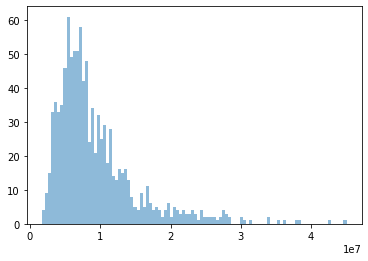

In [1214]:
# Before transfromation
plt_price = plt.hist(rs_data['price'], bins=100, alpha=0.5, label="data1")

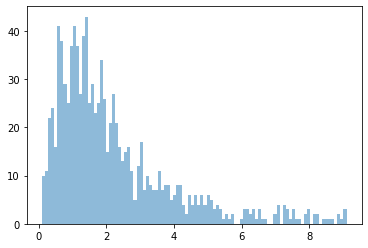

In [1219]:
# Before transfromation
plt_price = plt.hist(rs_data['Distance_to_hospital'], bins=100, alpha=0.5, label="data1")

#### From the above plots, we can see that both the plots shows the right skewed, Therefore, `log transfromation` will be suitable for these caese.

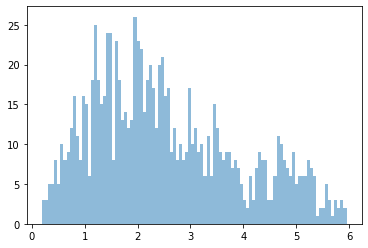

In [1571]:
plt_time = plt.hist(rs_data['Distance_to_sc'], bins=100, alpha=0.5, label="data1")

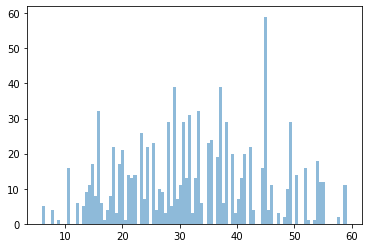

In [1572]:
plt_time = plt.hist(rs_data['travel_min_to_CBD'], bins=100, alpha=0.5, label="data1")

<b>From the above plots, we can see that both the plots shows the right skewed, but not has the strong skewed like the first two,
Therefore, `square root transfromation` will be suitable for these caese, because these data does not requires the stronger transformation.</b>

In [1215]:
# transfromation functions
import math

def df_sqrt(df_col):
    result_list = list()
    for i,row in rs_data.iterrows():
        result = math.sqrt(df_col[i])
        result_list.append(result)
    return result_list

def df_pow(df_col):
    result_list = list()
    for i,row in rs_data.iterrows():
        result = math.pow(df_col[i],2)
        result_list.append(result)
    return result_list

def df_log(df_col):
    result_list = list()
    for i,row in rs_data.iterrows():
        result = math.log(df_col[i])
        result_list.append(result)
    return result_list

#### From the above plot result, we conclude:
 - Log is good for `price` & `Distance_to_hospital`
 - sqrt is good for `Distance_to_sc` & `travel_min_to_CBD`

In [1216]:
# Transfrom data
# Log is good
price_li = df_log(rs_data['price'])
dis_hs = df_log(rs_data['Distance_to_hospital'])

# sqrt is good
dis_sc = df_sqrt(rs_data['Distance_to_sc'])
time_cbd = df_sqrt(rs_data['travel_min_to_CBD'])

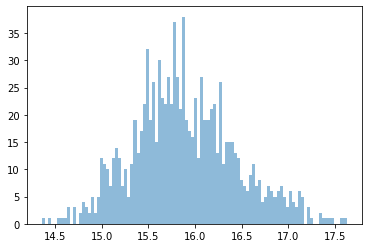

In [1266]:
# after transmation
plt_price_li = plt.hist(price_li, bins=100, alpha=0.5, label="data1")

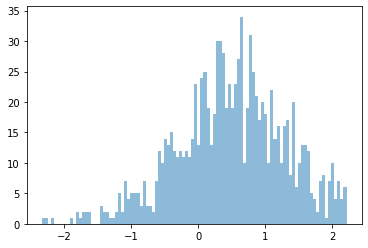

In [1218]:
# after transmation
plt_dic_hs = plt.hist(dis_hs, bins=100, alpha=0.5, label="data1")

<b>Now all the data has been reshaped and conforms to or very close to the normal distribution. </b>

## 2.1 Data Standardization(Z-Score Standardization)
### Why use Standardization ?
- When the measurement standards of all source data are different, if we directly input the source data to the machine learning algorithm, then different levels of data will affect the accuracy of the prediction.
- The machine will try to approximate the largest feature and ignore the smaller features, which will directly affect the accuracy of the model. For example, the distance is `30km` and the time is `1 hour`. Therefore, we need to use data standardization to unify different data under one order of magnitude so that different features have the same scale.

### Why choose Z-Score Standardization rather than Max-Min Normalisation?
- When distance measurement, covariance calculation and data do not conform to the normal distribution, we will choose to use Max-Min normalization, otherwise we will use Z-Score Standardization.

- Since our data is a continuous variable, the data processed by Z-Score standardization will be more in line with or close to a normal distribution which is excatly what we looking for in this task.

In [1221]:
from sklearn import preprocessing

In [1220]:
# create test df, only select the necessary columns
test_df = rs_data.filter(items=['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital'])

# use the transformed result
test_df['price'] = price_li
test_df['Distance_to_sc'] = dis_sc
test_df['travel_min_to_CBD'] = time_cbd
test_df['Distance_to_hospital'] = dis_hs

In [1222]:
# fit to the columns
std_scale = preprocessing.StandardScaler().fit(test_df[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']])
# re-scale the values
test_std = std_scale.transform(test_df[['price', 'Distance_to_sc', 'travel_min_to_CBD', 'Distance_to_hospital']]) # an array not a df

Check mean and standard deviation 

In [1224]:
print('Mean after standardisation:\nprice = {:.2f}, Distance_to_sc = {:.2f}'
      .format(test_std[:,0].mean(), test_std[:,1].mean()))
print('\nStandard deviation after standardisation:\nprice = {:.2f}, Distance_to_sc = {:.2f}'
      .format(test_std[:,0].std(), test_std[:,1].std()))

Mean after standardisation:
price = 0.00, Distance_to_sc = -0.00

Standard deviation after standardisation:
price = 1.00, Distance_to_sc = 1.00


### So far, the source data has been reshaped and standardized. we can use scatter plot to check some correlations between the data sets
- Red color represent `price` & `travel_min_to_CBD`
- Blue color represent `price` & `Distance_to_sc`
- Green color represent `price` & `Distance_to_hospital`

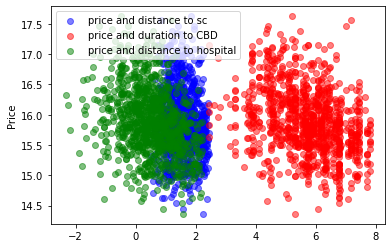

In [1243]:
plt.scatter(test_df['Distance_to_sc'], test_df['price'], color = 'blue', label='price and distance to sc',alpha=0.5)
plt.scatter(test_df['travel_min_to_CBD'], test_df['price'], color = 'red',label='price and duration to CBD', alpha=0.5)
plt.scatter(test_df['Distance_to_hospital'],test_df['price'],  color = 'green', label='price and distance to hospital', alpha=0.5)
plt.ylabel('Price')
plt.legend(loc='upper left')

- From the above plot, we cannot really find out any correlation between `price` and 3 predictors. But this is not meet with the common sense and lieanr assumptions also such result can not using for build linear model. 
- For more clear look, we use `Pearson correlation coefficient` to have a look.
- Obviously, we have more than 500 samples, so the p-value should be reliable.
- We want to see how `price` change when `distance` changes, so for function inputs should be `pearsonr(distance, price)`

In [1158]:
from scipy.stats import pearsonr

In [1264]:
print("Correlation between prince and time to CBD: {:.5f}".format(pearsonr(test_df['travel_min_to_CBD'], test_df['price'])[1]))
print("Correlation between prince and distance to sc: {:.5f}".format(pearsonr(test_df['Distance_to_sc'], test_df['price'])[1]))
print("Correlation between prince and distance to hospital: {:.5f}".format(pearsonr(test_df['Distance_to_hospital'], test_df['price'])[1]))

Correlation between prince and time to CBD: 0.00000
Correlation between prince and distance to sc: 0.00164
Correlation between prince and distance to hospital: 0.00000


As we can see, the p-values of these three correlations are all 0, and we cannot satisfy the linear assumption, so these source data cannot be used to build a linear model.